<a href="https://colab.research.google.com/github/ronen94/DadaptationToyImplementation/blob/main/Deep_Learning_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torch.optim as optim


In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])
test_data = torchvision.datasets.CIFAR10(root="~/", download=True,train=False, transform=transform)
train_data = torchvision.datasets.CIFAR10(root="~/", download=True,train=True, transform=transform)

100%|██████████| 170498071/170498071 [00:08<00:00, 20792841.74it/s]


Extracting /root/cifar-10-python.tar.gz to /root/
Files already downloaded and verified


In [3]:

test_data_indicies = np.random.choice(np.arange(len(test_data.data)), int(len(test_data.data) / 10))
train_data_indicies = np.random.choice(np.arange(len(train_data.data)), int(len(train_data.data) / 10))

test_subset = Subset(test_data, test_data_indicies)
train_subset = Subset(train_data, train_data_indicies)


test_data_sampled, test_data_sampled_labels = [], []

for test_sample, test_label in test_subset:
  test_data_sampled.append(test_sample)
  test_data_sampled_labels.append(test_label)

test_data_sampled = np.array(test_data_sampled)

train_data_sampled, train_data_sampled_labels = [], []

for train_sample, train_label in train_subset:
  train_data_sampled.append(train_sample)
  train_data_sampled_labels.append(train_label)

train_data_sampled = np.array(train_data_sampled)


In [ ]:
# create flattened datasets for linear models or fully connected NN's
train_data_sampled_flattened = train_data_sampled.reshape(train_data_sampled.shape[0], train_data_sampled.shape[1] * train_data_sampled.shape[2] * train_data_sampled.shape[3])
test_data_sampled_flattened = test_data_sampled.reshape((test_data_sampled.shape[0], test_data_sampled.shape[1] * test_data_sampled.shape[2] * test_data_sampled.shape[3]))

Use SVM classifier to create a baseline

In [ ]:
clf_linear = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='linear'))
clf_linear.fit(train_data_sampled_flattened, train_data_sampled_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', kernel='linear'))])

In [ ]:
clf_rbf =  make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf'))
clf_rbf.fit(train_data_sampled_flattened, train_data_sampled_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [ ]:
# print train and test accuracies
linear_train_score = clf_linear.score(train_data_sampled_flattened, train_data_sampled_labels)
linear_test_score = clf_linear.score(test_data_sampled_flattened, test_data_sampled_labels)
print(f"Linear svm train score {linear_train_score}, linear svm test score {linear_test_score}")

rbf_train_score = clf_rbf.score(train_data_sampled_flattened, train_data_sampled_labels)
rbf_test_score = clf_rbf.score(test_data_sampled_flattened, test_data_sampled_labels)
print(f"rbf svm train score {rbf_train_score}, linear svm test score {rbf_test_score}")


Linear svm train score 1.0, linear svm test score 0.268
rbf svm train score 0.7504, linear svm test score 0.418


In [ ]:
train_subset.

AttributeError: 'Subset' object has no attribute 'shape'

In [4]:
train_subset_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_subset_loader = DataLoader(test_subset, batch_size=64, shuffle=True)


In [12]:
example, _ = train_subset[0]
INPUT_SIZE = example.shape[0] * example.shape[1] * example.shape[2]
OUTPUT_SIZE = 10
import torch.nn.init as init

class BaseForwardNetwork(nn.Module):

  def __init__(self, layer_num: int, layer_width: int, weight_std: float, apply_xavier_init:bool=False):
    super().__init__()
    first_layer = nn.Linear(INPUT_SIZE, layer_width)
    last_layer = nn.Linear(layer_width, OUTPUT_SIZE)
    linear_layers = [nn.Linear(layer_width, layer_width) for _ in range(layer_num - 1)]
    linear_layers.insert(0, first_layer)
    linear_layers.append(last_layer)
    linear_layers = self.initalize_linear_layers(weight_std,apply_xavier_init, linear_layers)
    all_layers = [nn.Flatten()]
    for layer in linear_layers:
      all_layers.append(layer)
      all_layers.append(nn.ReLU())
    all_layers.pop() # remove the last relu
    self.neural_net = nn.Sequential(*all_layers)



  def initalize_linear_layers(self, weight_std, apply_xavier_init, linear_layers):
      if not apply_xavier_init:
        for layer in linear_layers:
          weights = torch.normal(mean=torch.zeros_like(layer.weight), std=weight_std)
          biases = torch.normal(mean=torch.zeros_like(layer.bias), std=weight_std)
          with torch.no_grad():
            layer.weight = nn.Parameter(weights)
            layer.bias = nn.Parameter(biases)
      else:
        for layer in linear_layers:
          init.xavier_uniform_(layer.weight)
          init.constant_(layer.bias, 0)

      return linear_layers


  def forward(self, x):
      return self.neural_net(x)


In [6]:
def train_and_evaluate_one_pass(cur_model, train_data_loader, test_data_loader, learning_rate=0.001, momentum_coef=  0.99, optimizer = None):
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    if not optimizer:
      optimizer = optim.SGD(cur_model.parameters(), lr=learning_rate, momentum=momentum_coef)

    # Initialize lists to store metrics
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Training loop for one pass through the training data
    # running_loss = 0.0
    # correct_train = 0
    # total_train = 0

    for batch_idx, (data, target) in enumerate(train_data_loader):
        cur_model.train()  # Set the model to training mode
        optimizer.zero_grad()  # Zero the parameter gradients
        output = cur_model(data)  # Forward pass
        loss = criterion(output, target)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        # running_loss = loss.item()
        # _, predicted = torch.max(output.data, 1)
        # total_train = target.size(0)
        # correct_train = (predicted == target).sum().item()

        # train_accuracy = 100 * correct_train / total_train
        # train_losses.append(running_loss)
        # train_accuracies.append(train_accuracy)

        # Evaluate on train and test data
        cur_model.eval()  # Set the model to evaluation mode
        running_test_loss = 0.0
        running_train_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in train_data_loader:
                output = cur_model(data)
                loss = criterion(output, target)

                running_train_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()

        train_loss = running_train_loss / len(train_data_loader)
        train_accuracy = 100 * correct_test / total_test
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        with torch.no_grad():
            for data, target in test_data_loader:
                output = cur_model(data)
                loss = criterion(output, target)

                running_test_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()

        test_loss = running_test_loss / len(test_data_loader)
        test_accuracy = 100 * correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    print('Training completed for one pass through the training data')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return train_losses, train_accuracies, test_losses, test_accuracies

In [ ]:
def train(cur_model, train_data_loader, learning_rate=0.001, momentum_coef=  0.99, optimizer = None):
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    if not optimizer:
      optimizer = optim.SGD(cur_model.parameters(), lr=learning_rate, momentum=momentum_coef)

    # Initialize lists to store metrics
    for batch_idx, (data, target) in enumerate(train_data_loader):
        cur_model.train()  # Set the model to training mode
        optimizer.zero_grad()  # Zero the parameter gradients
        output = cur_model(data)  # Forward pass
        loss = criterion(output, target)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights



def evaluate_model(model, test_data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_data_loader:
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)  # Accumulate test loss
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    avg_test_loss = test_loss / total
    accuracy = 100 * correct / total

    return avg_test_loss, accuracy

In [ ]:
import itertools
# question 2.1 parameter search
std_params = [0.1, 0.5, 1, 2]
lr_params = [0.001, 0.01, 0.05, 0.1]
momentum_params = [0.5, 0.8, 0.95, 0.99]
params_dict = {}
for std, lr, m in itertools.product(*[std_params, lr_params, momentum_params ]):
  print('std: ', std)
  print('lr: ', lr)
  print('m: ', m)
  base_nn = BaseForwardNetwork(layer_num=1, layer_width = 256, weight_std =std)
  train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate_one_pass(base_nn, train_subset_loader, test_subset_loader, learning_rate = lr, momentum_coef=m)
  params_dict[f'std: {std}, lr: {lr}, momentum: {m}'] = {'train_losses' : train_losses, 'train_accuracies': train_accuracies, 'test_losses': test_losses, 'test_accuracies': test_accuracies}

std:  0.1
lr:  0.001
m:  0.5
Training completed for one pass through the training data
Test Loss: 2.5066, Test Accuracy: 16.90%
std:  0.1
lr:  0.001
m:  0.8
Training completed for one pass through the training data
Test Loss: 2.3569, Test Accuracy: 18.90%
std:  0.1
lr:  0.001
m:  0.95
Training completed for one pass through the training data
Test Loss: 2.0523, Test Accuracy: 27.90%
std:  0.1
lr:  0.001
m:  0.99
Training completed for one pass through the training data
Test Loss: 2.1016, Test Accuracy: 25.70%
std:  0.1
lr:  0.01
m:  0.5
Training completed for one pass through the training data
Test Loss: 2.2668, Test Accuracy: 22.30%
std:  0.1
lr:  0.01
m:  0.8
Training completed for one pass through the training data
Test Loss: 1.9807, Test Accuracy: 30.20%
std:  0.1
lr:  0.01
m:  0.95
Training completed for one pass through the training data
Test Loss: 1.9672, Test Accuracy: 29.00%
std:  0.1
lr:  0.01
m:  0.99
Training completed for one pass through the training data
Test Loss: 2.1605

In [7]:
import matplotlib.pyplot as plt

def plot_graphs(graph_name, train_loss, test_loss, train_accuracy, test_accuracy):
  plt.plot(np.arange(len(train_loss)), train_loss)
  plt.plot(np.arange(len(train_loss)), test_loss)
  plt.xlabel("epoch number")
  plt.ylabel("loss")
  plt.title(graph_name + "- loss")
  plt.show()

  plt.plot(np.arange(len(train_accuracy)), train_accuracy)
  plt.plot(np.arange(len(test_accuracy)), test_accuracy)
  plt.xlabel("epoch number")
  plt.ylabel("accuracy")
  plt.title(graph_name + "- accuracy")
  plt.show()

In [8]:
#best paeameters for baseline:

# std:  0.1
# lr:  0.01
# m:  0.8
baseline_std = 0.1
baseline_lr = 0.01
baseline_momentum= 0.8

base_nn = BaseForwardNetwork(layer_num=1, layer_width = 256, weight_std =baseline_std)
train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate_one_pass(base_nn, train_subset_loader, test_subset_loader, learning_rate = baseline_lr, momentum_coef=baseline_momentum)

Training completed for one pass through the training data
Train Loss: 1.9023, Train Accuracy: 32.04%
Test Loss: 2.0276, Test Accuracy: 31.27%


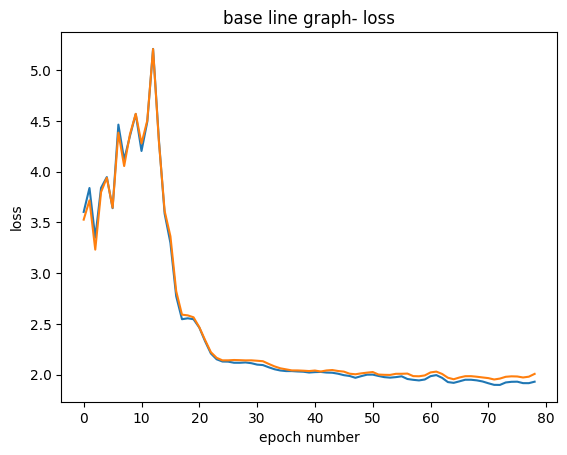

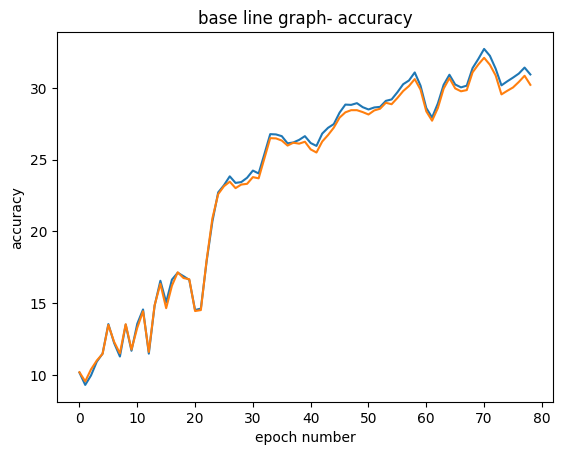

In [ ]:
plot_graphs("base line graph",train_losses, test_losses, train_accuracies,test_accuracies)

Training completed for one pass through the training data
Train Loss: 2.2417, Train Accuracy: 21.68%
Test Loss: 2.2737, Test Accuracy: 21.73%


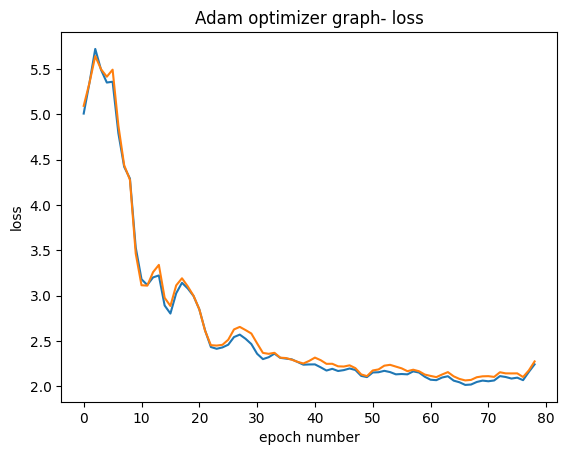

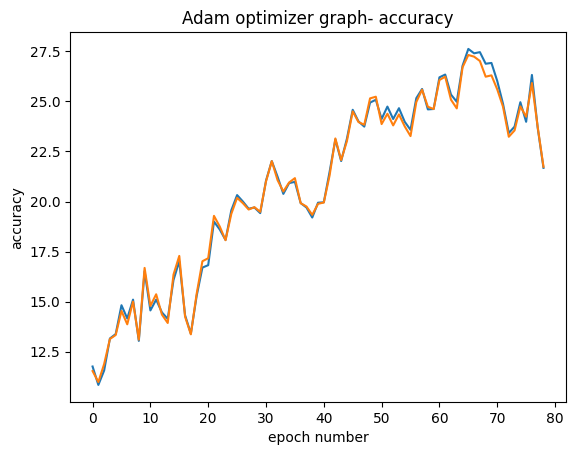

In [ ]:
# question 2.2 testing out adam optemizer:
base_nn = BaseForwardNetwork(layer_num=1, layer_width = 256, weight_std =baseline_std)
adam_optimizer = optim.Adam(base_nn.parameters())
train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate_one_pass(base_nn, train_subset_loader, test_subset_loader, optimizer =adam_optimizer )
plot_graphs("Adam optimizer graph",train_losses, test_losses, train_accuracies,test_accuracies)

Training completed for one pass through the training data
Train Loss: 1.9951, Train Accuracy: 24.68%
Test Loss: 2.0292, Test Accuracy: 24.28%


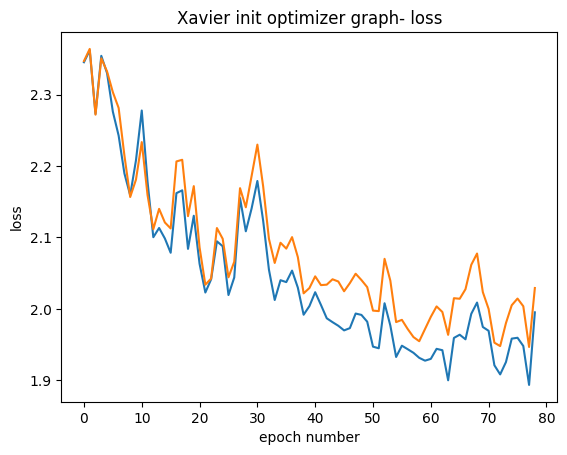

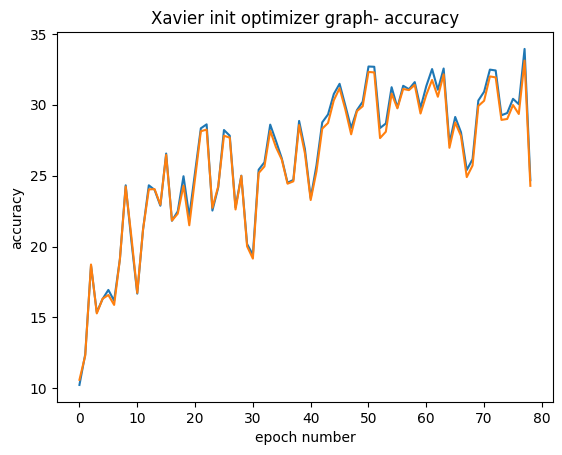

In [15]:
# question 2.3 xavier initalization
base_nn = BaseForwardNetwork(layer_num=1, layer_width = 256, weight_std =baseline_std, apply_xavier_init=True)
train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate_one_pass(base_nn, train_subset_loader, test_subset_loader, learning_rate = baseline_lr, momentum_coef=baseline_momentum)
plot_graphs("Xavier init optimizer graph",train_losses, test_losses, train_accuracies,test_accuracies)

In [ ]:
# question 2.4 Regularization and dropout


In [ ]:
# question 2.5 PCA whitening

In [ ]:
#question 2.6 Network Width

In [ ]:
# question 2.7 Networth depth